In [13]:
# !pip install -q "numpy<2"
# !pip install -q albumentations
# !pip install -q ultralytics

In [14]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🌐 https://c0z0c.github.io/jupyter_hangul
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = d:\GoogleDrive\codeit\영상수업실습\파트2_딥러닝_이미지생성


<module 'helper_c0z0c_dev' from 'd:\\GoogleDrive\\codeit\\영상수업실습\\파트2_딥러닝_이미지생성\\helper_c0z0c_dev.py'>

In [15]:
# 기본 라이브러리

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import average_precision_score

# --- 기타 라이브러리 ---
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
import albumentations as A
import IPython.display
#from tqdm import tqdm
from tqdm.notebook import tqdm

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as TF
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- 기타 ---
import re
import os
import sys
import json
import math
import random
import yaml
import shutil
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from datetime import datetime
from datetime import timezone, timedelta
import pytz
__kst = pytz.timezone('Asia/Seoul')

# GPU 설정
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

  # 재현 가능한 결과를 위해
np.random.seed(42)
torch.manual_seed(42)
if __device == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치:{__device}")

라이브러리 로드 완료 사용장치:cpu


### > 설정 < 플레그

In [16]:
# 디버그 모드 (필요시 True로 변경)
DEBUG_ON = False
if not helper.is_colab:
    DEBUG_ON = True
DEBUG_ON = False

IMAGE_SIZE_ORG=320 # 320을 이미지의 최대 크기로 사용
IMAGE_SIZE=320 # 320을 모델의 입력 크기로 사용
BATCH_SIZE=16

__MEAN_TENSOR = [0.485, 0.456, 0.406]
__STD_TENSOR = [0.229, 0.224, 0.225]
__MEAN_RGB = [123, 116, 103]
__STD_RGB = [58, 57, 57]

def mean_std(type=None, mean_tensor=None, std_tensor=None, mean_rgb=None, std_rgb=None):
    """
    Mean (RGB): [0.485, 0.456, 0.406]
    Std (RGB):  [0.229, 0.224, 0.225]
    Mean (RGB, 0~255): [123, 116, 103]
    Std (RGB, 0~255):  [58, 57, 57]
    """
    global __MEAN_TENSOR, __STD_TENSOR, __MEAN_RGB, __STD_RGB
    res_old = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if mean_tensor is not None:
        __MEAN_TENSOR = mean_tensor
    if std_tensor is not None:
        __STD_TENSOR = std_tensor
    if mean_rgb is not None:
        __MEAN_RGB = mean_rgb
    if std_rgb is not None:
        __STD_RGB = std_rgb

    res = {
        "mean_tensor": __MEAN_TENSOR,
        "std_tensor": __STD_TENSOR,
        "mean_rgb": __MEAN_RGB,
        "std_rgb": __STD_RGB
    }

    if res_old != res:
        print(f"변경사항 발견: { json.dumps(res_old, indent=2, ensure_ascii=False)} -> {json.dumps(res, indent=2, ensure_ascii=False)}")

    if type is None:
        return res
    return res.get(type, res)


print(f'이미지 원본크기:{IMAGE_SIZE_ORG} 모델입력크기:{IMAGE_SIZE} DEBUG_ON:{DEBUG_ON}')
print(f'평균 표준편차 {mean_std()}')

이미지 원본크기:320 모델입력크기:320 DEBUG_ON:False
평균 표준편차 {'mean_tensor': [0.485, 0.456, 0.406], 'std_tensor': [0.229, 0.224, 0.225], 'mean_rgb': [123, 116, 103], 'std_rgb': [58, 57, 57]}


### 1.2. 유틸리티 함수

#### 1.2.1 기본 유틸리티 함수

In [17]:
def get_tqdm_kwargs_old():
    """환경에 맞는 tqdm 설정 반환"""
    if helper.is_colab or 'ipykernel' in sys.modules:
        # Jupyter/Colab 환경
        # return {'disable': False, 'leave': True, 'position': 0, 'ncols': 60}  # 폭 60으로 지정
        return {'disable': False, 'leave': True, 'position': 0}
    else:
        # 일반 Python 환경
        #return {'disable': False, 'mininterval': 1, 'leave': True, 'ncols': 60}
        return {'disable': False, 'mininterval': 1, 'leave': True}

def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    root_path = os.path.join("D:\\", "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    modeling_path = "modeling_test"
    if DEBUG_ON:
        modeling_path = modeling_path +"_debug"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    modeling_path = "modeling_test"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, indent=""):
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return
    
    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- " + item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > 10:
                print(indent + "    " + f"[데이타파일: {img_count}개]")
            print_dir_tree(path, max_depth-1, indent + "    ")
        else:
            if 10 < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- " + item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f"  {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


#### 1.2.1 yolo 유틸리티 함수

In [18]:
# yolo_dataset_path

# C:\Users\sw1\.cache\kagglehub\datasets\devdgohil\the-oxfordiiit-pet-dataset\versions\2\yolo_dataset
def create_yolo_dataset_yaml(train_df, valid_df, test_df, yolo_dataset_path, ignore=False):
    """YOLO 형식의 데이터셋 yaml 파일 생성"""
        
    # YOLO 데이터셋 폴더 생성
    if os.path.exists(yolo_dataset_path):
        if ignore:
            print(f"Yolo 데이터셋 삭제 {yolo_dataset_path}")
            shutil.rmtree(yolo_dataset_path)
        else:
            print(f"Yolo 데이터셋 있음 {yolo_dataset_path}")
            print_dir_tree(yolo_dataset_path, max_depth=3)
            yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
            return yaml_path
    
    os.makedirs(yolo_dataset_path, exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "inf"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "trimaps"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "images", "test"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", "test"), exist_ok=True)

    # 이미지 복사 및 라벨 파일 생성
    def convert_to_yolo_format(df, split_name):
        pbar = tqdm(df.iterrows(), total=len(df), desc=f"yolo dataset {split_name}", **get_tqdm_kwargs())
        for _, row in pbar:
            # 이미지 복사
            src_img = row['image_path']
            if os.path.exists(src_img):
                dst_img = os.path.join(yolo_dataset_path, "images", split_name, f"{row['image_name']}.jpg")
                shutil.copy2(src_img, dst_img)

                src_trimaps = row['trimap_path']
                if os.path.exists(src_trimaps):
                    dst_trimaps = os.path.join(yolo_dataset_path, "trimaps", f"{row['image_name']}.png")
                    shutil.copy2(src_trimaps, dst_trimaps)
                
                # YOLO 형식 라벨 생성
                img_width = 0
                img_height = 0
                
                # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                x_center = 0.0
                y_center = 0.0
                bbox_width = 0.0
                bbox_height = 0.0
                
                if split_name != 'test':
                    if pd.isna(row['xmin']):
                        # 박스 정보 없으면 빈 라벨 파일 생성 (test셋)
                        open(label_file, 'w').close()
                        continue                    
                    # YOLO 형식 라벨 생성
                    img_width = row['width']
                    img_height = row['height']
                    
                    # bbox 좌표를 YOLO 형식으로 변환 (정규화된 중심점 + 너비/높이)
                    x_center = (row['xmin'] + row['xmax']) / 2 / img_width
                    y_center = (row['ymin'] + row['ymax']) / 2 / img_height
                    bbox_width = (row['xmax'] - row['xmin']) / img_width
                    bbox_height = (row['ymax'] - row['ymin']) / img_height
                    
                    # 클래스 ID (species_id - 1, 0: cat, 1: dog)
                    class_id = row['species_id'] - 1
                    
                    # 라벨 파일 생성
                    label_file = os.path.join(yolo_dataset_path, "labels", split_name, f"{row['image_name']}.txt")
                    with open(label_file, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

                # 추가 정보를 위하여 사용
                inf_file = os.path.join(yolo_dataset_path, "inf", f"{row['image_name']}.inf")
                with open(inf_file, 'w', encoding='utf-8') as f:
                    f.write(f"image_name: {row['image_name']}\n")
                    f.write(f"kind_id: {row['class_id']}\n") # 품종
                    f.write(f"species_id: {row['species_id']}\n")
                    f.write(f"breed_id: {row['breed_id']}\n")
                    f.write(f"species: {row['species']}\n")
            
    
    # 데이터 변환
    convert_to_yolo_format(train_df, "train")
    convert_to_yolo_format(valid_df, "val")
    convert_to_yolo_format(test_df, "test")

    # dataset.yaml 파일 생성
    dataset_config = {
        'path': yolo_dataset_path,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 2,  # 클래스 수
        'names': ['cat', 'dog']
    }
    
    yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"YOLO 데이터셋 생성 완료: {yolo_dataset_path}")
    return yaml_path

def yolo_dataset_to_dataframe(yaml_path):
    """
    YOLO dataset.yaml 파일을 참고하여 train/val/test DataFrame 생성 + inf 폴더 정보 추가
    """


    # yaml 파일 로드
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)

    base_path = config['path']
    splits = ['train', 'val', 'test'] if 'test' in config else ['train', 'val']
    dfs = {}

    for split in splits:
        img_dir = os.path.join(base_path, config[split])
        label_dir = os.path.join(base_path, 'labels', split) if split != 'test' else None
        inf_dir = os.path.join(base_path, 'inf') if os.path.exists(os.path.join(base_path, 'inf')) else None
        trimaps_dir = os.path.join(base_path, 'trimaps') if os.path.exists(os.path.join(base_path, 'trimaps')) else None

        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        records = []
        pbar = tqdm(img_files, total=len(img_files), desc=f"DataFrame from yolo dataset {split}", **get_tqdm_kwargs())
        for img_file in pbar:
            image_path = os.path.join(img_dir, img_file)
            image_name = os.path.splitext(img_file)[0]
            label_path = None
            class_id = None
            bbox = None
            inf_data = {}
            trimap_file = None

            if label_dir:
                label_file = os.path.join(label_dir, f"{image_name}.txt")
                if os.path.exists(label_file):
                    with open(label_file, 'r') as lf:
                        lines = lf.readlines()
                        if lines:
                            parts = lines[0].strip().split()
                            if len(parts) == 5:
                                class_id = int(parts[0])
                                x_center = float(parts[1])
                                y_center = float(parts[2])
                                w = float(parts[3])
                                h = float(parts[4])
                                bbox = (x_center, y_center, w, h)
                                label_path = label_file

            # inf 폴더 정보 추가
            if inf_dir:
                inf_file = os.path.join(inf_dir, f"{image_name}.inf")
                if os.path.exists(inf_file):
                    with open(inf_file, 'r', encoding='utf-8') as f_inf:
                        for line in f_inf:
                            if ':' in line:
                                k, v = line.strip().split(':', 1)
                                inf_data[k.strip()] = v.strip()

            if trimaps_dir:
                trimap_file = os.path.join(trimaps_dir, f"{image_name}.png")
                if os.path.exists(trimap_file) is False:
                    trimap_file = None

            record = {
                'image_name': image_name,
            }
            record.update({
                'split': split,
                'class_id': class_id,
                'bbox': bbox,
            })
            if inf_data:
                record.update(inf_data)
            record.update({
                'image_path': image_path,
                'label_path': label_path,
                'trimap_path': trimap_file,
            })
            records.append(record)

        dfs[split] = pd.DataFrame(records)

    train_df = dfs.get('train', None)
    valid_df = dfs.get('val', None)
    test_df = dfs.get('test', None)

    print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}, test_df: {test_df.shape}")
    return train_df, valid_df, test_df

def yolo_to_coco_bbox(yolo_bbox, img_width=IMAGE_SIZE, img_height=IMAGE_SIZE):
    """
    yolo_bbox: [x_center, y_center, w, h] (정규화된 값)
    반환: [xmin, ymin, xmax, ymax] (pixel 좌표)
    """
    x_center, y_center, w, h = yolo_bbox
    xmin = (x_center - w / 2) * img_width
    ymin = (y_center - h / 2) * img_height
    xmax = (x_center + w / 2) * img_width
    ymax = (y_center + h / 2) * img_height
    return [xmin, ymin, xmax, ymax]

print("yolo 유틸리티 함수 로드 완료")

yolo 유틸리티 함수 로드 완료


## 2. VAE

In [19]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [20]:
device = __device
print("사용하는 device:", device)

# MNIST 데이터셋 준비
# 데이터 전처리를 위해 ToTensor 변환을 적용
transform = transforms.Compose([transforms.ToTensor()])

# 학습용 MNIST 데이터셋 다운로드 및 로드
# 손글씨 데이타
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)


사용하는 device: cpu


In [32]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)
        
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self. fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [22]:
beta = 1.0
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [23]:
raise ValueError("Invalid model type")

ValueError: Invalid model type

In [ ]:
### 모델 학습: 2D 잠재 공간으로 학습 ###
# 잠재 공간 차원 설정 (여기서는 2차원)
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("2D 잠재 공간으로 학습 시작...")

pbar = tqdm(range(num_epochs), desc="Training VAE", **get_tqdm_kwargs())
for epoch in pbar:
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)  # 데이터 GPU로 이동 (가능한 경우)
        optimizer.zero_grad()   # 기울기 초기화
        recon_batch, mu, logvar = model(data)  # 순전파 진행
        loss = loss_function(recon_batch, data, mu, logvar)  # 손실 계산
        loss.backward()         # 역전파
        train_loss += loss.item()
        optimizer.step()        # 가중치 업데이트

    # 에포크마다 평균 손실 출력
    pbar.set_postfix(loss=train_loss / len(trainloader.dataset))


In [ ]:
model_save_name = "vae_model_test"  # 저장할 파일명(확장자 제외)
model_name = "modeling_test"        # 저장할 폴더명
best_kwargs = {}                    # 추가 정보(필요 없으면 빈 dict)

best_model_pth = save_model_dict(
    model,
    path=get_path_modeling(model_name),
    pth_name=model_save_name,
    kwargs=best_kwargs
)
print(f"모델이 저장되었습니다: {best_model_pth}")

In [34]:
# 저장된 모델 경로 및 파일명 지정
model_name = "modeling_test"
model_save_name = "vae_model_test"

# 모델 state_dict와 정보 불러오기
model_state, model_info = load_model_dict(
    path=get_path_modeling(model_name),
    pth_name=model_save_name
)

# 새로운 VAE 인스턴스 생성 후 state_dict 적용
latent_dim = model_info['init_args'].get('latent_dim', 2)  # 저장된 정보에서 latent_dim 가져오기(없으면 2)
model = VAE(latent_dim=latent_dim)
model.load_state_dict(model_state)
model.to(device)  # 반드시 추가!
model.eval()  # 평가 모드로 전환

print("모델 불러오기 완료:", model_info)




모델 불러오기 완료: {'class_name': 'VAE', 'init_args': {}, 'str': 'VAE(\n  (fc1): Linear(in_features=784, out_features=400, bias=True)\n  (fc21): Linear(in_features=400, out_features=2, bias=True)\n  (fc22): Linear(in_features=400, out_features=2, bias=True)\n  (fc3): Linear(in_features=2, out_features=400, bias=True)\n  (fc4): Linear(in_features=400, out_features=784, bias=True)\n)', 'repr': 'VAE(\n  (fc1): Linear(in_features=784, out_features=400, bias=True)\n  (fc21): Linear(in_features=400, out_features=2, bias=True)\n  (fc22): Linear(in_features=400, out_features=2, bias=True)\n  (fc3): Linear(in_features=2, out_features=400, bias=True)\n  (fc4): Linear(in_features=400, out_features=784, bias=True)\n)', 'modules': ['VAE', 'Linear', 'Linear', 'Linear', 'Linear', 'Linear'], 'file_name': 'vae_model_test.pth'}


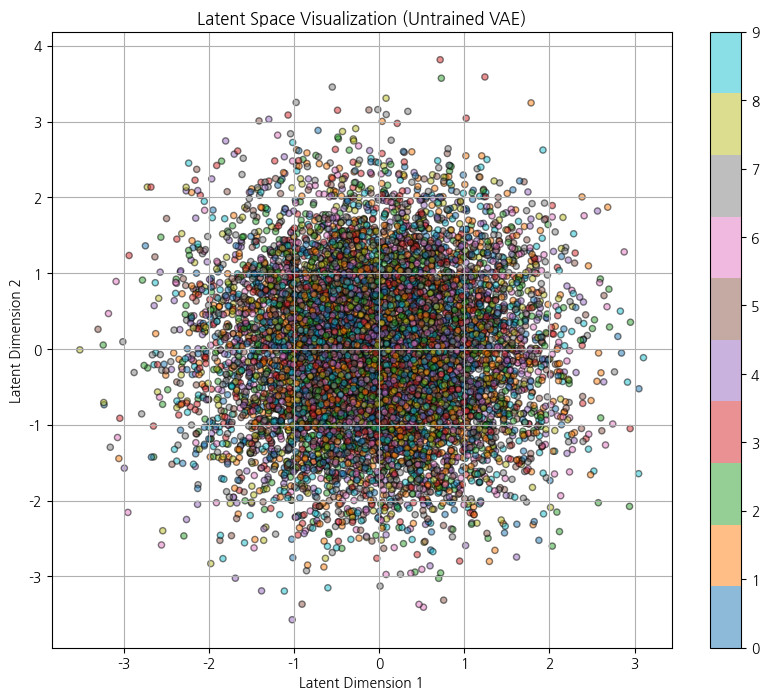

In [35]:
# 1. 학습 전 모델로 잠재 공간 시각화
vae_untrained = VAE(latent_dim=2).to(device)
vae_untrained.eval()

all_z_untrained = []
all_labels_untrained = []

with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)
    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = vae_untrained.encode(data.view(-1, 28 * 28))
        z = vae_untrained.reparameterize(mu, logvar)
        all_z_untrained.append(z.cpu().numpy())
        all_labels_untrained.append(labels.numpy())
    all_z_untrained = np.concatenate(all_z_untrained)
    all_labels_untrained = np.concatenate(all_labels_untrained)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_z_untrained[:, 0], all_z_untrained[:, 1], c=all_labels_untrained, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (Untrained VAE)')
plt.grid(True)
plt.show()

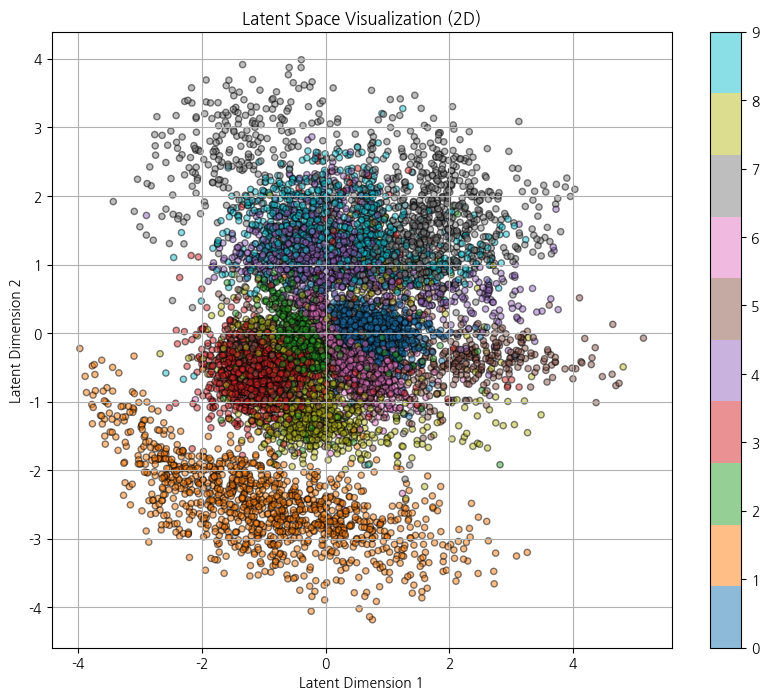

In [36]:
### 잠재 공간 시각화 (2D) 및 테스트 데이터셋 처리 ###
model.eval()  # 평가 모드로 전환
all_z = []    # 모든 잠재 변수 저장 리스트
all_labels = []  # 해당 이미지의 레이블 저장 리스트

# 테스트 데이터셋 다운로드 및 로드 (학습 데이터와는 별개)
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    # 테스트 데이터셋에 대해 인코딩 및 잠재 변수 샘플링 진행
    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)

    # 2D 잠재 공간에 대해 산점도(scatter plot) 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization (2D)')
    plt.grid(True)
    plt.show()


In [40]:
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)
    grid_y = np.linspace(-3, 3, 20)
    figure = np.zeros((28 * len(grid_x), 28 * len(grid_y)))
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decode(z_sample).cpu().numpy()
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit



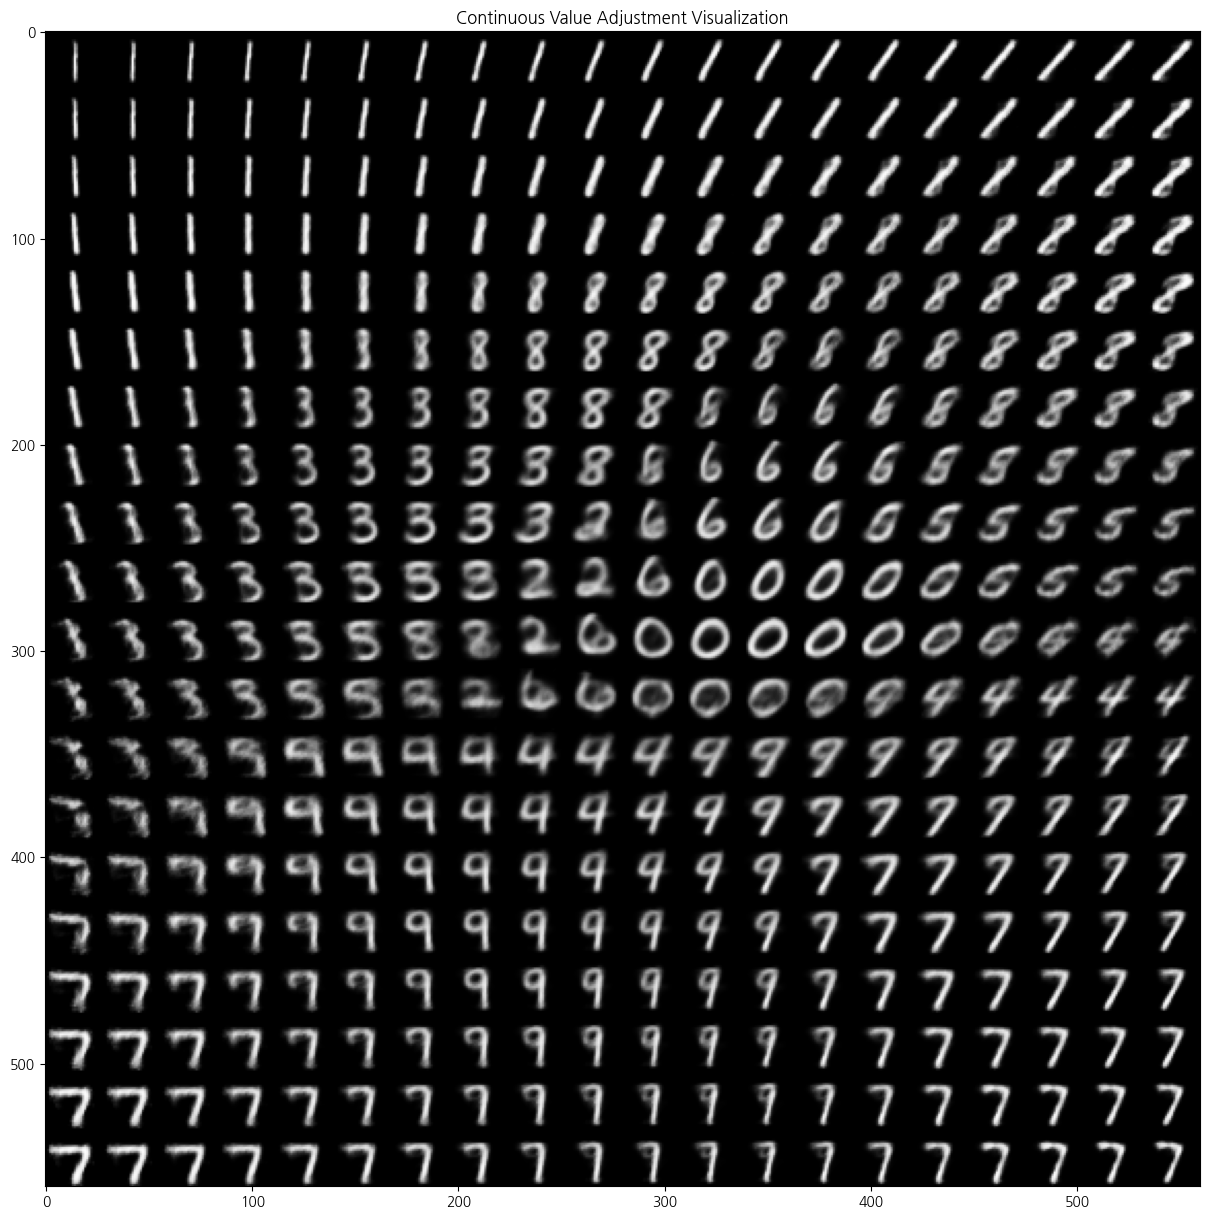

In [37]:
### 잠재 공간을 활용한 새로운 데이터 생성 (연속적 값 조정)
# 잠재 공간에서 샘플을 생성하여 디코더로 복원한 후, 그 결과를 그리드 형태로 시각화합니다.
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)  # x축 범위 및 샘플링 개수 설정
    grid_y = np.linspace(-3, 3, 20)  # y축 범위 및 샘플링 개수 설정
    figure = np.zeros((28 * 20, 28 * 20))  # 전체 이미지를 저장할 빈 배열 생성
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # 현재 좌표 (xi, yi)를 잠재 변수로 변환 후 디코딩
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()


In [ ]:
### 잠재 공간 차원 확장: 128D로 재학습 ###
# 잠재 공간의 차원을 128로 확장하여 학습하면 재구성 품질이 개선될 수 있습니다.
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("128D 잠재 공간으로 학습 시작...")
pbar = tqdm(range(num_epochs), desc="Training VAE", **get_tqdm_kwargs())
for epoch in pbar:
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    pbar.set_postfix(loss=train_loss / len(trainloader.dataset))
    #print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


In [38]:
model_save_name = "vae_model_test2"  # 저장할 파일명(확장자 제외)
model_name = "modeling_test"        # 저장할 폴더명
best_kwargs = {}                    # 추가 정보(필요 없으면 빈 dict)

best_model_pth = save_model_dict(
    model,
    path=get_path_modeling(model_name),
    pth_name=model_save_name,
    kwargs=best_kwargs
)
print(f"모델이 저장되었습니다: {best_model_pth}")

모델이 저장되었습니다: D:\GoogleDrive\modeling_test\modeling_test\vae_model_test2.pth


In [43]:
# 저장된 모델 경로 및 파일명 지정
model_save_name = "vae_model_test2"
model_name = "modeling_test"

# 모델 state_dict와 정보 불러오기
model_state, model_info = load_model_dict(
    path=get_path_modeling(model_name),
    pth_name=model_save_name
)

# 새로운 VAE 인스턴스 생성 후 state_dict 적용
latent_dim = model_info['init_args'].get('latent_dim', 128)  # 저장된 정보에서 latent_dim 가져오기(없으면 2)
model = VAE(latent_dim=latent_dim)
model.load_state_dict(model_state)
model.to(device)  # 반드시 추가!
model.eval()  # 평가 모드로 전환

print("모델 불러오기 완료:", model_info)



모델 불러오기 완료: {'class_name': 'VAE', 'init_args': {}, 'str': 'VAE(\n  (fc1): Linear(in_features=784, out_features=400, bias=True)\n  (fc21): Linear(in_features=400, out_features=128, bias=True)\n  (fc22): Linear(in_features=400, out_features=128, bias=True)\n  (fc3): Linear(in_features=128, out_features=400, bias=True)\n  (fc4): Linear(in_features=400, out_features=784, bias=True)\n)', 'repr': 'VAE(\n  (fc1): Linear(in_features=784, out_features=400, bias=True)\n  (fc21): Linear(in_features=400, out_features=128, bias=True)\n  (fc22): Linear(in_features=400, out_features=128, bias=True)\n  (fc3): Linear(in_features=128, out_features=400, bias=True)\n  (fc4): Linear(in_features=400, out_features=784, bias=True)\n)', 'modules': ['VAE', 'Linear', 'Linear', 'Linear', 'Linear', 'Linear'], 'file_name': 'vae_model_test2.pth'}


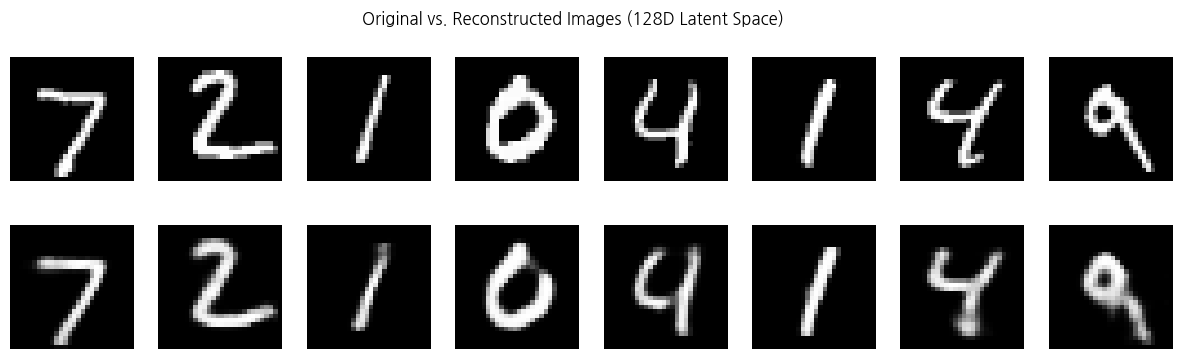

In [44]:
### 128D 잠재 공간 재구성 결과 시각화 ###
model.eval()
with torch.no_grad():
    # 테스트 데이터셋에서 일부 데이터를 선택하여 재구성 결과 확인
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    # 원본 이미지와 재구성 이미지를 나란히 비교하여 시각화
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # 첫 번째 행: 원본 이미지
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 두 번째 행: 재구성된 이미지
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Original vs. Reconstructed Images (128D Latent Space)")
    plt.show()
